# Проект по теме 71. (1,2)-Задача коммивояжёра-2
<p style='text-align: right;'> по предмету Сложность вычислений, осень 2022 - зима 2023 </p>
<p style='text-align: right;'> подготовил студент 3 курса МФТИ Бахарев Никита </p>

## <a id="plan">План</a>

0. [План](#plan)
1. [Аннотация](#annotation)
2. [Введение](#introduction)
3. [Техническая часть](#technical_part)
4. [Эксперименты на случайном графе](#random_graph_experiment)
5. [Эксперименты на других графах:](#other_graph_experiment)
* [Wikipedia](#wikipedia)
* [Дороги Москвы](#moscow)
6. [Источники](#sources)


## <a id="annotation">[Аннотация](#plan)</a>

Traveling Salesman Problem (TSP) - известная задача на графе. Мы будем рассматривать следующую модификацию задачи: дан полный неориентированный граф с весами ребер 1 или 2. Нужно найти гамильтонов цикл минимального веса. 

Мы сравним алгоритм, предложенный в статье Бермана–Карпински [\[1\]](#sources1), с другими алгоритмами на различных графах.

## <a id="introduction">[Введение](#plan)</a>
Traveling Salesman Problem (TSP) одна из самых старых NP-полных задач. Она имеет реальное прикладное значение. Наилучшее известное приближение результата на произвольном графе - $\frac{8}{7}$ - дает алгоритм Бермана-Карпински. 
Приближенное решение TSP с весами 1, 2 с точностью $< \frac{535}{534}$ является NP-трудной задачей [\[3\]](#sources3). 

Мы реализуем несколько эвристических алгоритмов, чтобы оценить эффективность алгоритма Бермана-Карпински. Будем показано, что на разреженных графах последний оказывается лучше реализованных эвристик.

## <a id="technical_part">[Техническая часть](#plan)</a>

Опишем сам алгоритм.
Будем считать, что наличие ребра в графе означает ребро веса 1, отстутствие - ребро веса 2.

Будем хранить множество ребер $A$. Оно задает вершинно непересекающиеся пути и циклы.

Будем постепенно обновлять $A$ операцией $A := A \oplus C$, где C - еще одно множество ребер, $\oplus$ - симметрическая разность множеств. 

Применяем операцию, только если выполнено:
1) $A \oplus C$ корректно, то есть новое множество задает вершинно непересекающиеся пути и циклы.
2) число вершинно непересекающихся путей + циклов уменьшилось или
3) число вершинно непересекающихся путей + циклов не изменилось и число вершин в циклах увеличилось

$C$ ищем просто перебором. Мы перебираем в порядке увеличения размера C.

Далее соединяем вершинно непересекающиеся пути и циклы (которые интерпретируются как пути) в один гамильтонов путь ребрами веса 2. Далее он соединяется в гамильтонов цикл.

## <a id="random_graph_experiment">[Эксперименты на случайном графе](#plan)</a>



Будем генерировать случайный граф на $ n$ вершинах с вероятностью $ p = \frac{1}{2}$ ребра и $ q =   1 -  p$ отсутствия ребра. (На самом деле наличие ребра означает ребро веса 1, отсутствие ребра - ребро веса 2).

Будем запускать разные алгоритмы на 1 секунду и сравнивать результаты.

Поскольку в таком графе асимптотически почти наверное будет гамильтонов цикл [\[2\]](#sources2), разумно сравнивать отношения результата к размеру графа $ n$, так как на практике оптимальный результат будет близок к $ n$. 

$ n$ будем брать от 2 до 1000, т.к. на больших графах будут алгоритмы с совсем плохой асимптотикой не успеют найти хорошее приближение ответа.

Инициализируем вспомогательные функции:

In [6]:
from tqdm import tqdm
from os import system

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sys

from numpy import genfromtxt

In [7]:
sns.set(style='darkgrid', font_scale=2, palette='Set1')

In [8]:
def prepare_drawing(xlabel, ylabel, title):
    plt.figure(figsize=(12, 8))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

In [9]:
def set_up_xticks(start, step, count):
    ticks = np.arange(0, count + step, step)
    ticks_with_start = np.append([start], ticks[1:])
    plt.xticks(ticks_with_start - start, ticks_with_start)

In [10]:
def save_results(results, file_name):
    df = pd.DataFrame(np.array(results))

    df.to_csv(file_name)

In [11]:
def load_results(file_name):
    return genfromtxt(file_name, delimiter=',')[1:, 1]

In [12]:
def draw_result_graph(cycle_results, title, start=2, step=100):
    prepare_drawing('размер графа', 'вес цикла : размер графа', title)
    set_up_xticks(start, step, len(cycle_results))
    sns.lineplot(data=cycle_results, linewidth=2.5)
    
def draw_first100_graphs(cycle_results, title='Начало того же графика'):
    draw_result_graph(cycle_results, title, 2, 10)
    plt.xlim((0, 100));

Функция генерирует случаный граф фиксированного размера и seed и запускает алгоритм (с указанный solver'ом в коде):

In [13]:
def calculate_result(graph_size, seed=0):    
    !./generate_graph.sh {graph_size} {seed}
    res = !./run.sh
    if len(res) != 1:
        # ошибка выполнения
        print(graph_size, seed, res)
        sys.stdout.flush()
        
    return int(res[0])

In [14]:
def run_random_graphs(max_graph_size):
    results = []

    for graph_size in tqdm(range(2, max_graph_size + 1)):
        results.append(calculate_result(graph_size) / graph_size)
    
    return results

### Используем Solver как в статье Бермана–Карпински
и возвращаем последний найденный цикл (он будет лучшим среди всех полученных циклов).

In [39]:
MAX_GRAPH_SIZE = 1000

In [42]:
results = run_random_graphs(MAX_GRAPH_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [21:09<00:00,  1.27s/it]


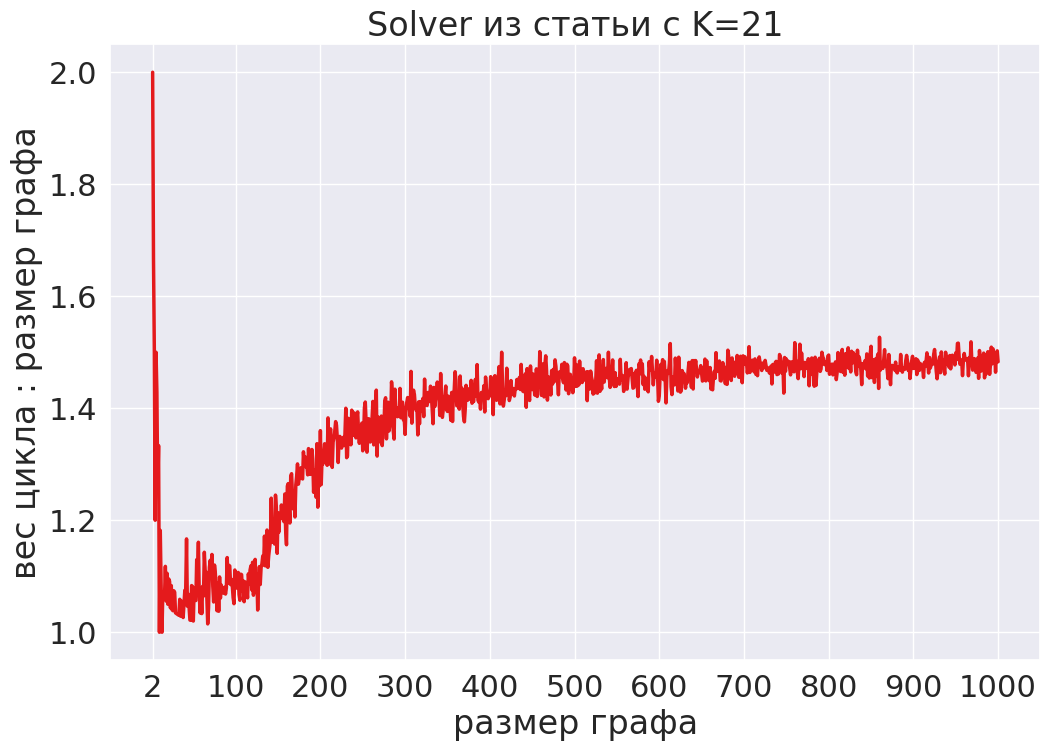

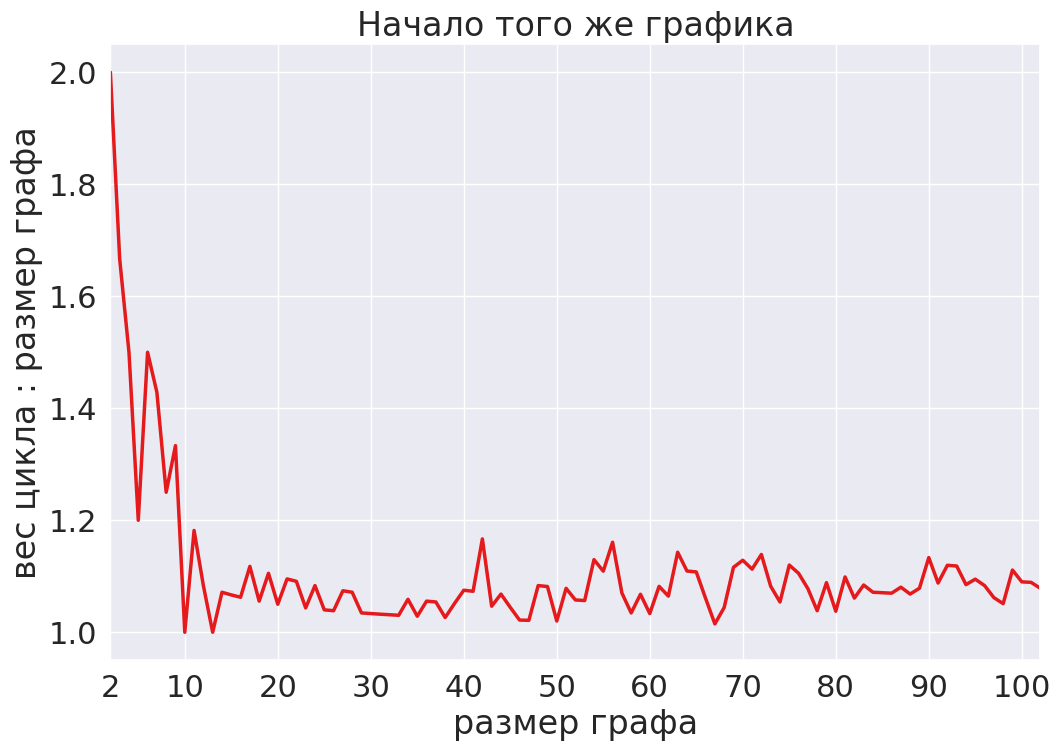

In [71]:
draw_result_graph(results, 'Solver из статьи с K=21')
draw_first100_graphs(results)

In [45]:
save_results(results, 'approximate_original_solver_k21.csv')

### RandomPermutationSolver алгоритм

Генерируем случайную перестановку, перебираем начиная с нее все перестановки. Возвращаем наилучший по стоимости полученный цикл.

In [46]:
results = run_random_graphs(MAX_GRAPH_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [21:58<00:00,  1.32s/it]


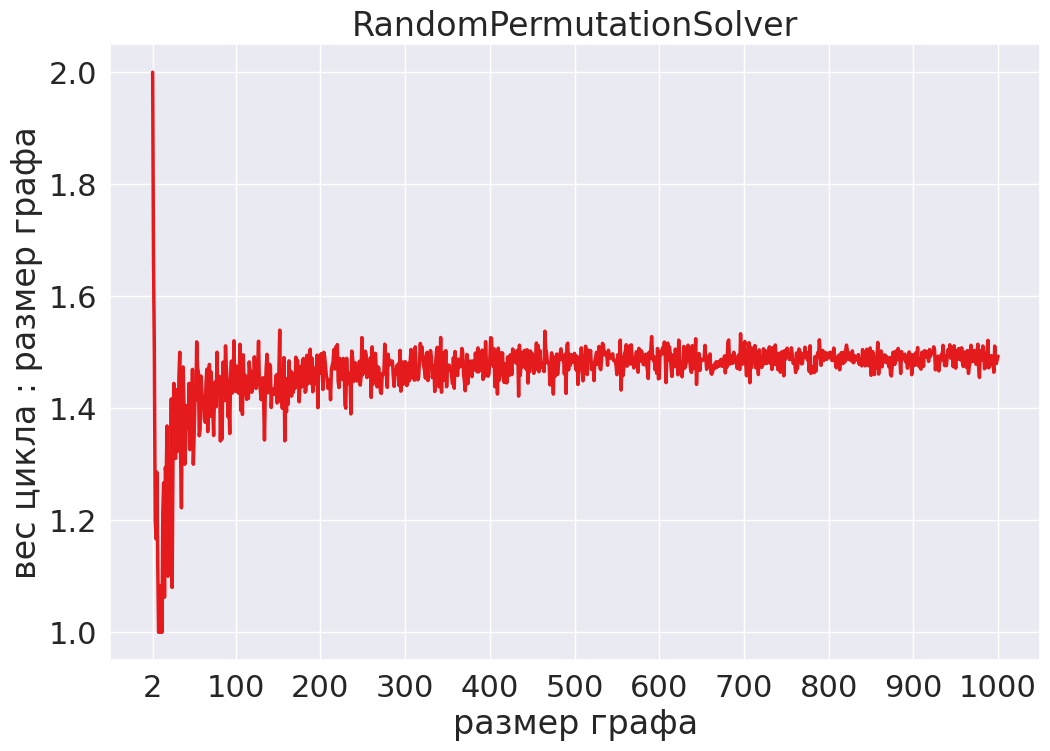

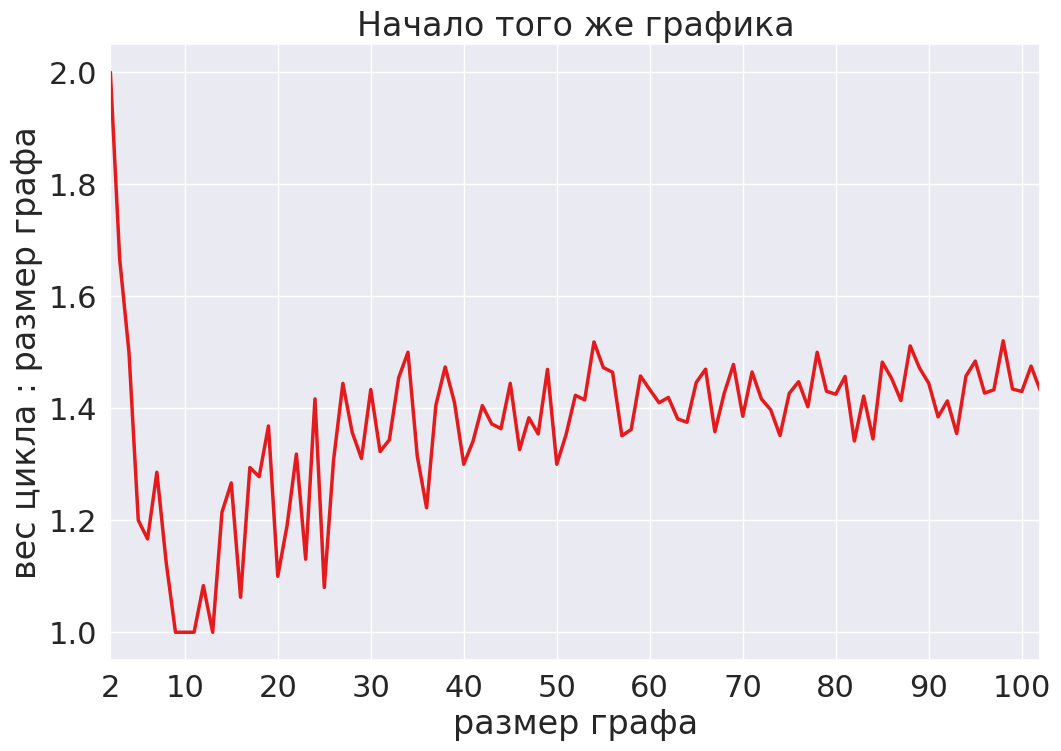

In [79]:
draw_result_graph(results, 'RandomPermutationSolver')
draw_first100_graphs(results)

In [49]:
save_results(results, 'random_permutation_solver.csv')

### RandomUnionSolver

Генерируем случайную перестановку $permutation$, далее формируем вершинно-непересекающиеся пути (изначально пути из 1 вершины).

Каждая вершина $ v$ лежит ровно в одном пути. Будем называть вершину краевой, если в подграфе пути $ deg $  $v \le 1$. Таким образом, пути $\ge$ 2 вершин имеют ровно 2 различные краевые вершины.

<pre>
for v in permutation:
    if v не краевая:
        continue
    if существует u : есть ребро (v, u) и u - краевая:
        объединить соответствующие пути
</pre>

Замечание: после прохода циклом больше не найдется таких двух краевых вершин $ v$ и $ u$, что есть ребро ($ v$, $ u$)

будем перебирать случайные $permutation$ пока не закончится время. Вернем наилучший найденный результат.

In [51]:
results = run_random_graphs(MAX_GRAPH_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [20:59<00:00,  1.26s/it]


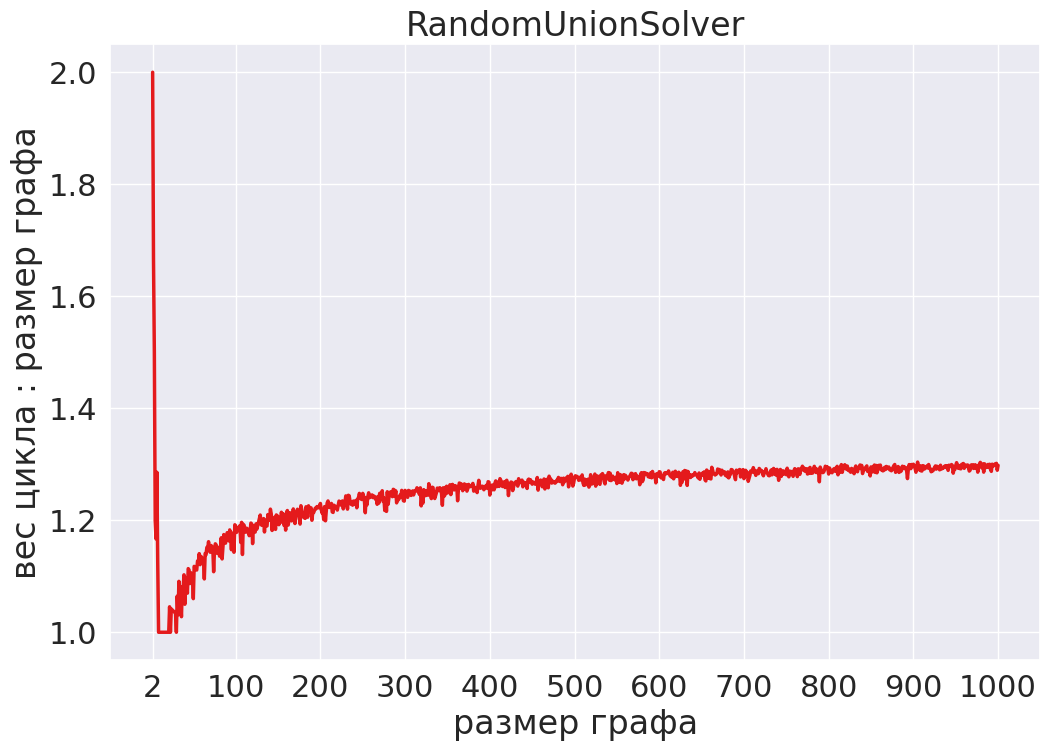

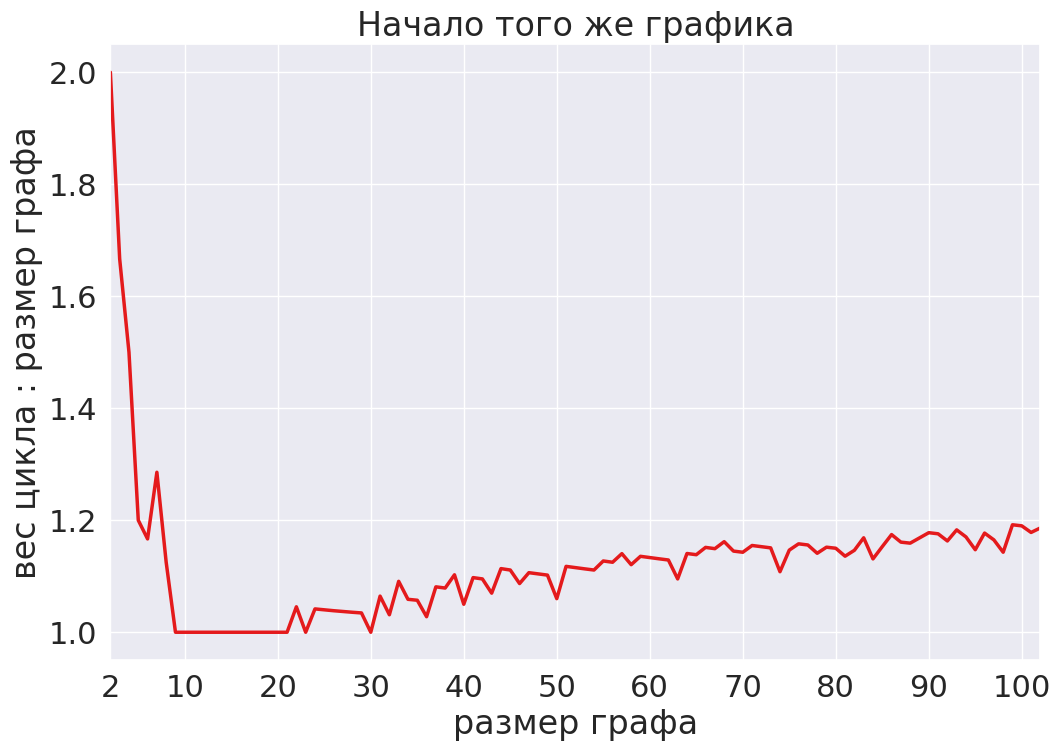

In [73]:
draw_result_graph(results, 'RandomUnionSolver')
draw_first100_graphs(results)

In [53]:
save_results(results, 'random_union_solver.csv')

### TreeMaxPathSolver

Пока время не закончилось:


Возьмем случайную вершину $ r$. Запустим DFS($ r$), получим какое-то дерево DFS. В нем найдем диаметр (путь максимальной длины), удалим его из графа и запустимся рекурсивно.

В конце получим вершинно-непересекающиеся пути, соединим их ребрами веса 2. Обновим результат, если получился цикл меньшего веса.



Покажем, что TreeMaxPathSolver за один запуск находит цикл стоимости $\le  n + 1$ с вероятностью $ \ge 0.288$.

Будем считать, что порядок обхода графа детерминирован заранее, то есть для каждой вершины $ v$ сгенерирована фиксированная перестановка. При обходе DFS($ v$) выбирается первая вершина $ u$ из перестановки, которая не была посещена, и есть ребро ($ v$, $ u$). 

Далее $P$( ... $\mid$ ... ) означает условную вероятность.

$P$(найдено дерево диаметра $\ n$) $\ge$ $P$(найдено дерево диаметра $n$ **и** $ r$ в дереве имеет ровно одного потомка (а значит в дереве нет "разветвлений")) = $P$($ r$ имеет хотя бы одно ребро)$P$(потомок $ r$ имеет хотя бы одно ребро не в $ r \mid  r$ имеет хотя бы одно ребро)$P$(следующий потомок имеет ребро в непосещенные вершины $\mid$ посетили 3 вершины, начиная от r)...$P$(следующий потомок имеет ребро в непосещенные вершины $\mid$ посетили $\ n$ - 1 вершины, начиная от $\sf r$) = $ (1 - q^{n - 1}))(1 - q^{n - 2}))...(1 - q^{1}))$

Применим монотонную функцию $\ln$, оценим результат и применим $exp$:

$
\ln (1 - q^{n - 1}))(1 - q^{n - 2}))...(1 - q^{1})) = \sum \limits _{i = 1} ^{n - 1}\ln(1 - q^i) = \sum \limits _{i = 1} ^{n - 1}\sum _\limits {k = 1} ^{+\infty}-\frac{q^{ik}}{k} \ge -\sum \limits _{i = 1} ^{+\infty}\sum _\limits {k = 1} ^{+\infty}\frac{q^{ik}}{k}
$

Покажем, что полученный ряд сходится. По условию $q \in (0, 1)$.

$ 0 \le \sum \limits _{i = 1} ^{+\infty}\sum _\limits {k = 1} ^{+\infty}\frac{q^{ik}}{k} \le \sum \limits _{i = 1} ^{+\infty}\sum _\limits {k = 1} ^{+\infty}\frac{q^{ik}}{1} = \sum \limits _{i = 1} ^{+\infty}\frac{q^i}{1 - q^i} \le \sum \limits _{i = 1} ^{+\infty}\frac{q^i}{1 - q}$ сх-ся.

Тогда

$
-\sum \limits _{i = 1} ^{+\infty}\sum _\limits {k = 1} ^{+\infty}\frac{q^{ik}}{k} = -\sum \limits _{k = 1} ^{+\infty}q^{k}\bigl (\sum \limits _ {d | k}{} \frac{1}{d} \bigr) = -\sum \limits _{k = 1} ^{+\infty}\frac{q^{k}}{k}\bigl(\sum \limits _ {d | k}{}d\bigr) 
$

Оценим сверху $\sum \limits _ {d | k}{}d$

Для каждого $k$ имеем $\le \sqrt{k}$ пар делителей, в каждой паре сумма $x + \frac{n}{x}$, где $x \in \{1, 2, ..., n\}$. Максимум функции достигается при $x \in \{1, n\}$. Отсюда $\sum \limits _ {d | k}{}d \le \sqrt{k}(k + 1).$

$-\sum \limits _{k = 1} ^{+\infty}\frac{q^{k}}{k}\bigl(\sum \limits _ {d | k}{}d\bigr) \ge -\sum \limits _{k = 1} ^{+\infty}q^{k}\sqrt{k} - \sum \limits _{k = 1} ^{+\infty}\frac{q^{k}}{\sqrt{k}} $

Далее найдем циклом частичную сумму ряда до какого-то слагаемого $N - 1$, а остаток оценим маленькой величиной.

$\sum \limits _{k = N} ^{+\infty}q^{k}\sqrt{k} + \sum \limits _{k = N} ^{+\infty}\frac{q^{k}}{\sqrt{k}} \le 2\sum \limits _{k = N} ^{+\infty}q^{k}k = 2q\bigl(\sum \limits _{k = N} ^{+\infty}q^{k}\bigr)' = 2q\bigl(\frac{q^N}{1 - q}\bigr)' = 2\frac{Nq^{N}(1-q) + q^{N+1}}{(1-q)^2} \le 4\frac{Nq^{N}(1-q)}{(1-q)^2} \le 4Nq^{N}$

Вспомним, что $q = \frac{1}{2}$. Положим $N := 100$. 

$4Nq^N < \frac{400}{1000^{10}} < 10^{-27}$

In [5]:
def get_sum_of_divisors(value: int) -> int:
    result = 0
    i = 1
    while i * i < value:
        if value % i == 0:
            result += i
            result += value // i
            
        i += 1
    
    if i * i == value:
        result += i
    
    return result

Частичная сумма $exp \bigl(-\sum \limits _{k = 1} ^{N - 1}\frac{q^{k}}{k}\bigl(\sum \limits _ {d | k}{}d\bigr)\bigr)$:

In [27]:
from decimal import Decimal

N = 100
q = Decimal(0.5)

result = Decimal(0) 
q_power_k = Decimal(q)

for k in range(1, N):
    result += Decimal(get_sum_of_divisors(k)) / Decimal(k) * q_power_k
    q_power_k *= q

result = (-result).exp()
error = (Decimal(10) ** (-27)).exp()
    
print('exp(-частичная сумма): {0:.5f}'.format(result))
print('Погрешность: {0:.27f}'.format(error))
print('Результат в интервале:')
print('{0:.28f}'.format(result / error))
print('{0:.28f}'.format(result * error))

exp(-частичная сумма): 0.28879
Погрешность: 1.000000000000000000000000001
Результат в интервале:
0.2887880950866024212788997216
0.2887880950866024212788997222


In [56]:
results = run_random_graphs(MAX_GRAPH_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [14:27<00:00,  1.15it/s]


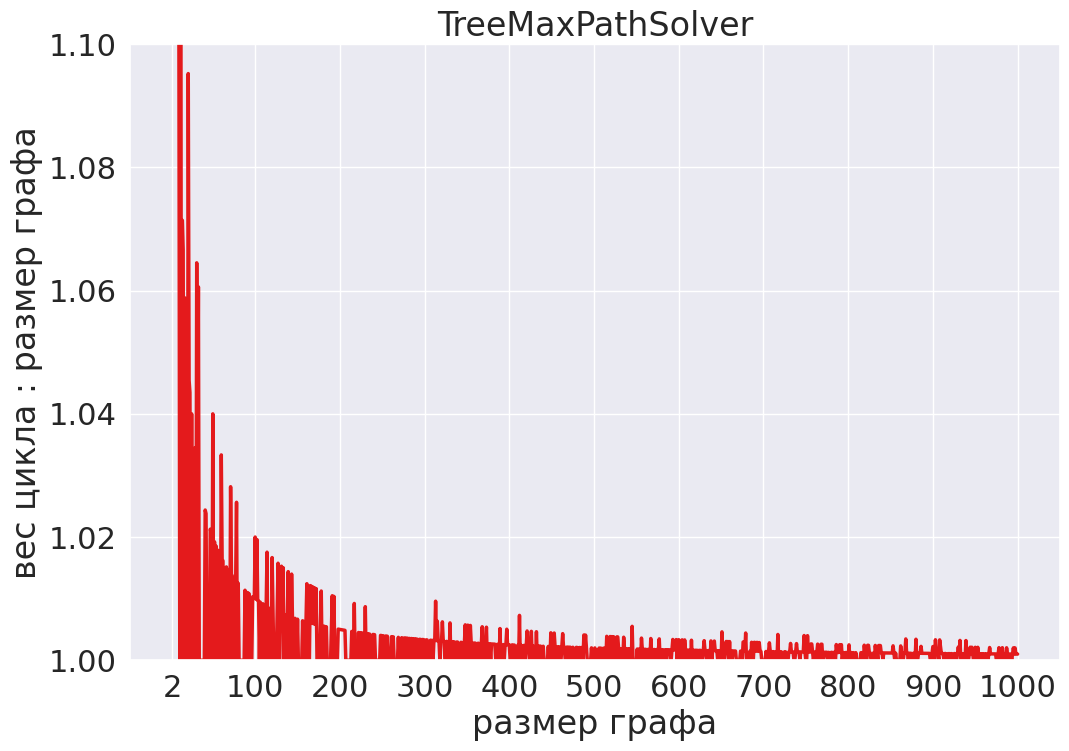

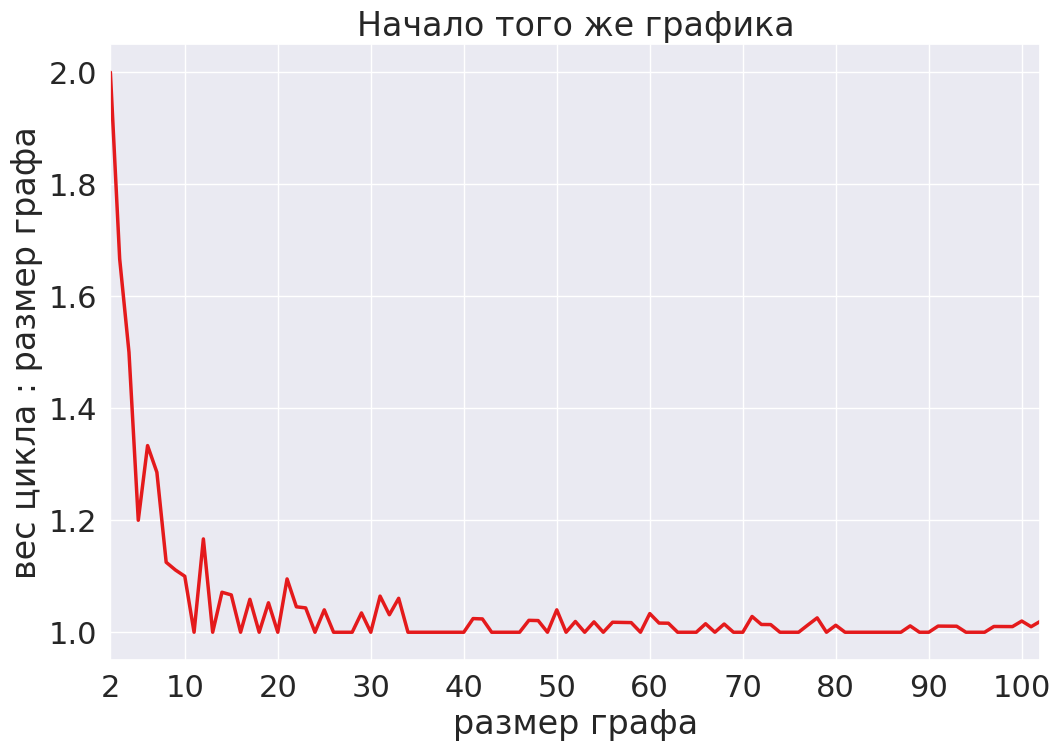

In [74]:
results = load_results('tree_max_path_solver.csv')
draw_result_graph(results, 'TreeMaxPathSolver')
plt.ylim((1.0, 1.1))
draw_first100_graphs(results)

In [64]:
save_results(results, 'tree_max_path_solver.csv')

### Сравним Solver'ы на одном графике:

In [75]:
def compare_solvers(files, names, title="Сравнение Solver'ов", draw_legend=True): 
    prepare_drawing('размер графа', 'вес цикла : размер графа', title)

    for name, data_file_name in zip(names, files):
        plt.plot(load_results(data_file_name), linewidth=2.5, alpha=0.7)

    if draw_legend:
        plt.legend(names)

In [76]:
FILES_CSV = ['approximate_original_solver_k21.csv', 'random_permutation_solver.csv', 'random_union_solver.csv', 
             'tree_max_path_solver.csv']
SOLVERS_NAMES = ['ApproximateOriginalSolver', 'RandomPermutationSolver', 'RandomUnionSolver', 'TreeMaxPathSolver']

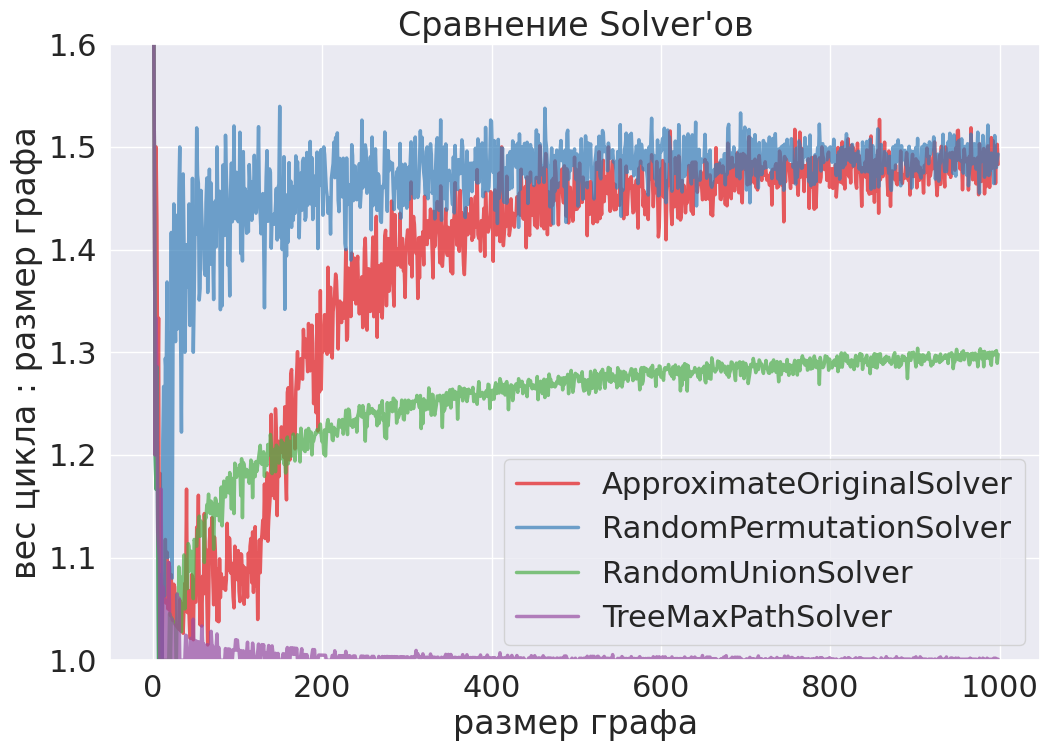

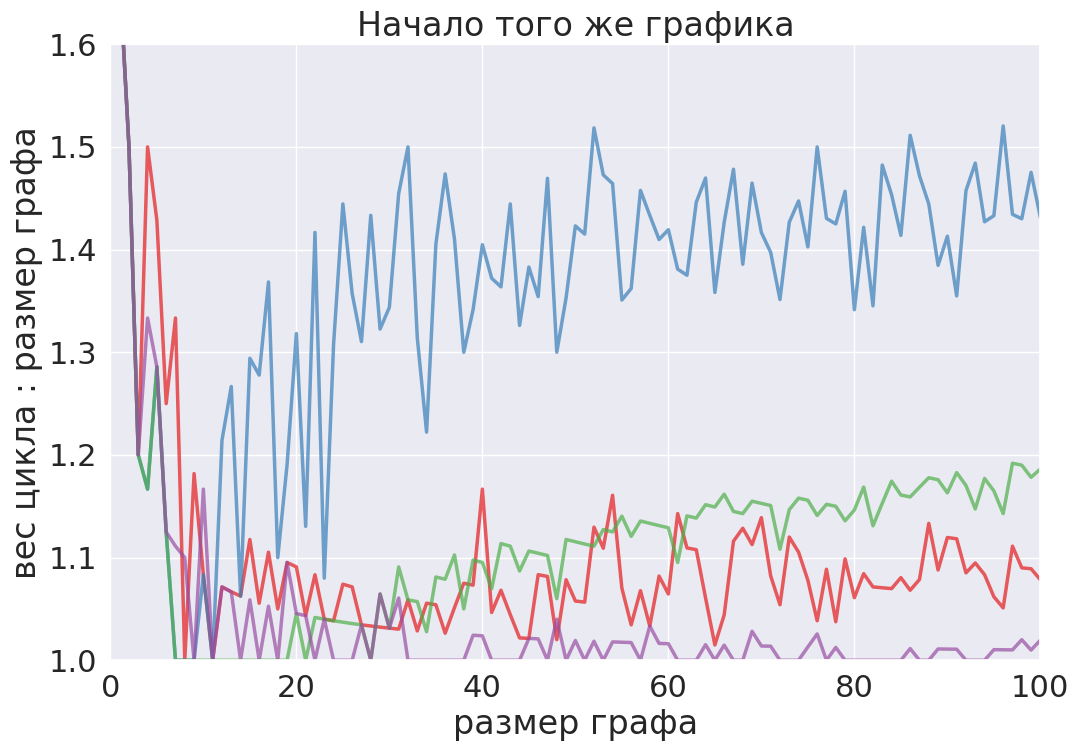

In [77]:
compare_solvers(FILES_CSV, SOLVERS_NAMES)
plt.ylim(1.0, 1.6);
compare_solvers(FILES_CSV, SOLVERS_NAMES, 'Начало того же графика', False)
plt.xlim(0, 100);
plt.ylim(1.0, 1.6);

## <a id="other_graph_experiment">[Эксперименты на других графах](#plan)</a>

### <a id="wikipedia">[Wikipedia](#plan)</a>

Выберем какую-нибудь стартовую страницу на wikipedia. Начнем ходить по ссылкам на странице. Будем игнорировать некоторые ссылки, например на картинки или вспомогательную информацию. Причем будем брать только первые (самые верхние, близкие к началу страницы) 10 ссылок на странице. 
Это сделано по двум причинам: 
1) на странице может быть слишком много ссылок, из-за чего получается слишком скучные графы;
2) поисковые роботы ценят в большей степени контент ближе к началу страницы, т.к. там скорее всего наиболее релевантные данные на странице.

Будем запускать solver'ы на графах, содержащих первые $n$ вершин из bfs'а, где $2 \leq n \leq 1000$ 

Много кода для парсинга страниц:

In [29]:
import requests
from time import sleep
from bs4 import BeautifulSoup
from typing import Tuple
from url_normalize import url_normalize
from queue import Queue
from typing import Optional
from urllib.request import urlopen
from urllib.parse import urlparse, urldefrag, urljoin

In [64]:
def download_from_the_internet(url) -> Optional[str]:
    try:
        return urlopen(url).read().decode('utf-8')
    except KeyboardInterrupt:
        raise
    except:
        return None

    
def extract_links_from_html(url, html: str) -> list:
    parser = BeautifulSoup(html)
    return [urljoin(url, link.get('href')) for link in parser.findAll('a')]


def extract_text_info_from_html(html):
    soup = BeautifulSoup(html, features="html.parser")
    for script in soup(["script", "style"]):
        script.extract()
    
    text = soup.get_text()
    lines = (line.strip() for line in text.splitlines())
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    text = '\n'.join(chunk for chunk in chunks if chunk)

    title = soup.find('title').string
    
    return {'text': text, 'title': title}
    

def is_wiki_article(url):
    if 'simple.wikipedia' not in url:
        return False

    prohibited = ['Category', 'Special', 'Wikipedia',
                  'php', 'Help', '#', '.jpg', '.png', '.ogg']
    
    for token in prohibited:
        if token in url:
            return False
        
    return True

In [65]:
START_PAGE = 'https://simple.wikipedia.org/wiki/graph'

In [122]:
def load_web_pages(seed: str, max_downloads: int, max_graph_size: int, filtration_function):
    '''
    BFS'ом обходим страницы
    max_loads - максимальное число ссылок, по которым мы перейдем со страницы.
    max_graph_size - максимальное число вершин
    filtration_function - какие url'ы игнорировать
    
    returns:
    
    vertex_order: list[str] - порядок, в котором обходились вершины. на i-ом месте i-ая вершина
    graph: dict[list[str]] - список смежности графа.
    '''

    already_visited = set()

    
    already_visited.add(seed)
    
    used_index = 0
    vertex_order = []
    vertex_order.append((seed, 0))
    # нужно, чтобы не получить блокировку от wikipedia.
    SLEEP_TIME = 0.01
    # определяем, какие вершины попадут в граф
    while used_index < len(vertex_order) <  max_graph_size:
        main_url, dist = vertex_order[used_index]
        used_index += 1
        
        main_url = url_normalize(main_url)
        html = download_from_the_internet(main_url)
        
        children_links = extract_links_from_html(main_url, html)
        
        sleep(SLEEP_TIME)

        downloaded = 0
        for child in children_links:
            if len(vertex_order) >= max_graph_size:
                break
                
            normalized_url_child = url_normalize(child)
            
            if normalized_url_child == main_url:
                continue
            
            if normalized_url_child not in already_visited and filtration_function(child):
                already_visited.add(child)
                vertex_order.append((normalized_url_child, dist + 1))
                downloaded += 1
                if downloaded >= max_downloads:
                    break
    # подгружаем ребра между найденными вершинами     
    vertex_order = {vertex for vertex, _ in vertex_order}
    graph = {}
    
    for vertex in vertex_order:
        graph.setdefault(vertex, set())
        
        html = download_from_the_internet(vertex)
        
        children_links = extract_links_from_html(vertex, html)
        sleep(SLEEP_TIME)
        
        for child in children_links:
            normalized_url_child = url_normalize(child)
            if normalized_url_child == vertex or normalized_url_child not in already_visited:
                continue
            graph.setdefault(normalized_url_child, set())
            graph[normalized_url_child].add(vertex)
            graph[vertex].add(normalized_url_child)
                
    return vertex_order, graph

In [123]:
%time vertex_order, graph = load_web_pages(START_PAGE, 10, 1000, is_wiki_article)

CPU times: user 1min 1s, sys: 1.51 s, total: 1min 2s
Wall time: 6min 51s


In [126]:
len(vertex_order)

1000

In [128]:
edges_count = 0
for item in graph:
    edges_count += len(graph[item])
    
edges_count

15634


Вспомогательные функции для запуска:

In [129]:
get_vertex_index = {}
for i, vertex in enumerate(vertex_order):
    get_vertex_index[vertex] = i

In [35]:
def count_edges(use_first_vertices: int, vertex_order, graph):
    result = 0
    for i, parent in enumerate(vertex_order):
        if i >= use_first_vertices:
            break
        for vertex in graph[parent]:
            result += int(get_vertex_index[vertex] < use_first_vertices)
                
    return result


def write_graph(use_first_vertices: int, vertex_order, graph, file_path='input.txt'):
    with open(file_path, 'w') as graph_file:
        graph_file.write(f'{use_first_vertices} {count_edges(use_first_vertices, vertex_order, graph) // 2}\n')
        
        for parent_index, parent in enumerate(vertex_order):
            if parent_index >= use_first_vertices:
                break
            for vertex in graph[parent]:
                vertex_index = get_vertex_index[vertex]
                if parent_index < vertex_index < use_first_vertices:
                    graph_file.write(f'{parent_index} {vertex_index}\n')

In [36]:
def run_current_graph():    
    res = !./run.sh
    if len(res) != 1:
        # ошибка выполнения
        print(res)
        sys.stdout.flush()
        return None
        
    return int(res[0])


def run_graphs(max_graph_size):
    result = []
    for i in tqdm(range(2, max_graph_size + 1)):
        write_graph(i, vertex_order, graph)
        run_res = run_current_graph()
        if run_res is None:
            break
        result.append(run_res / i)
    return result

def run_and_draw_and_save(title, csv_name):
    results = run_graphs(MAX_GRAPH_SIZE)
    draw_result_graph(results, title)
    draw_first100_graphs(results)
    save_results(results, csv_name)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [16:48<00:00,  1.01s/it]


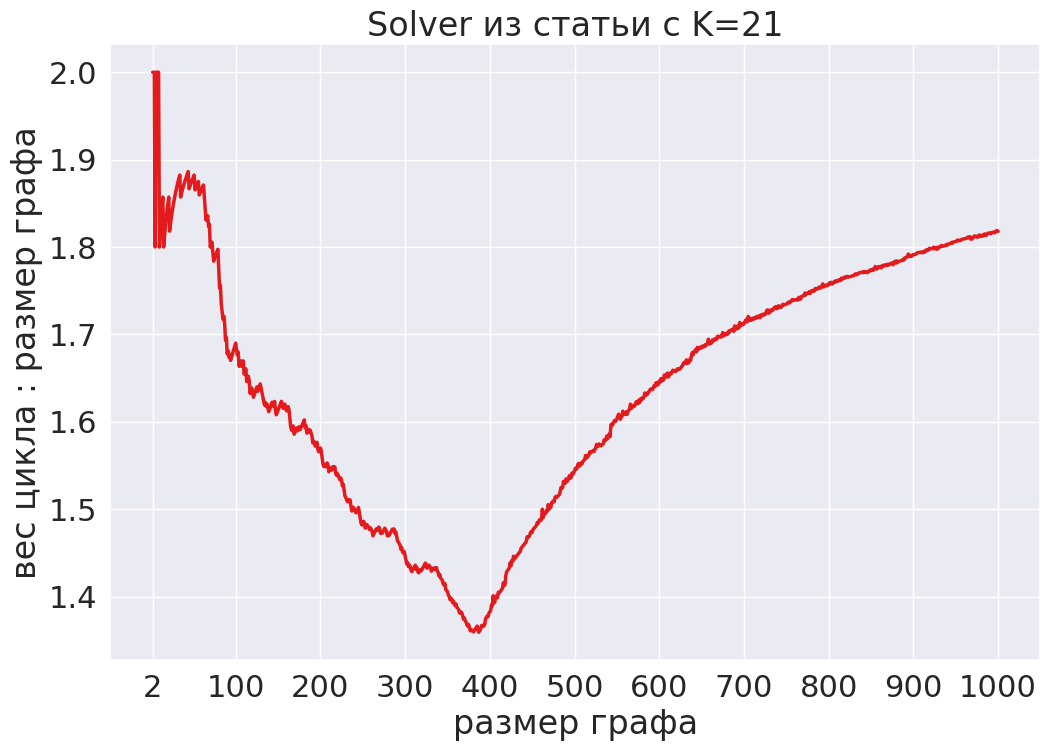

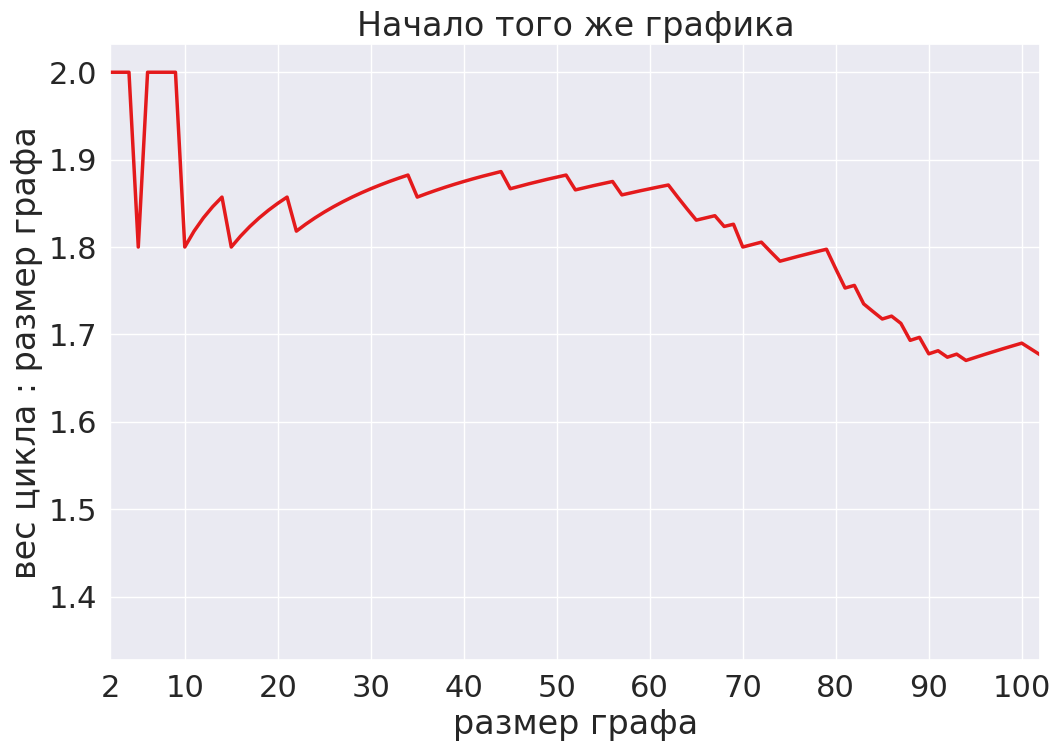

In [227]:
run_and_draw_and_save('Solver из статьи с K=21', 'wiki_approximate_original_solver_k21.csv')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [17:00<00:00,  1.02s/it]


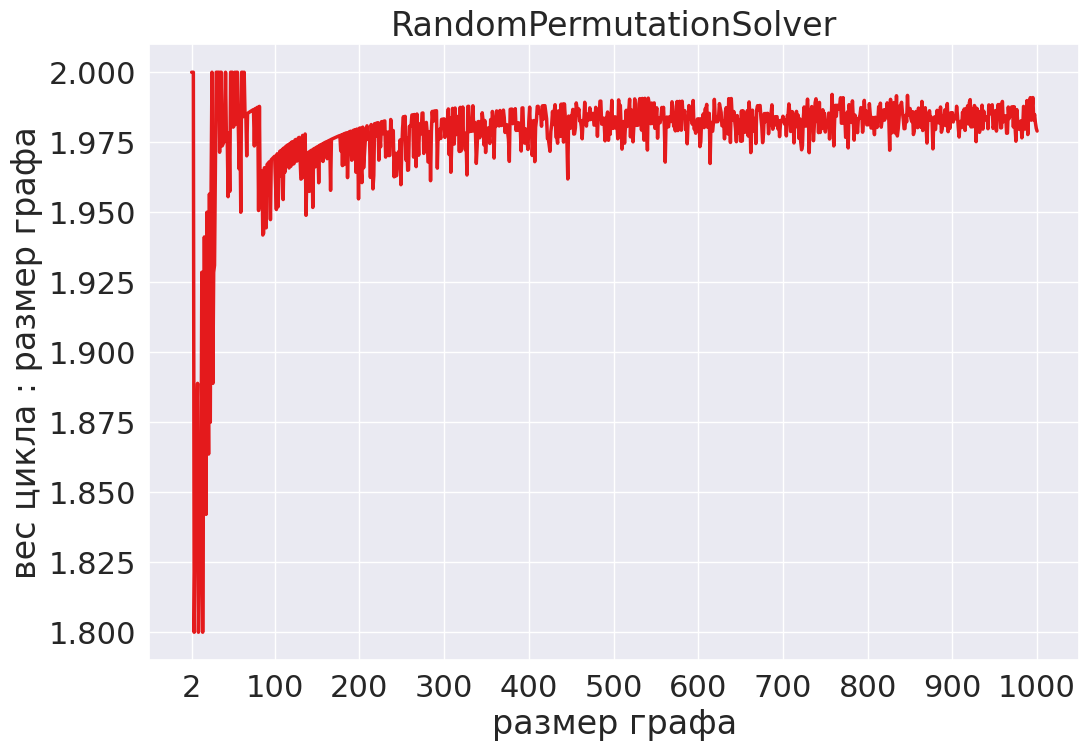

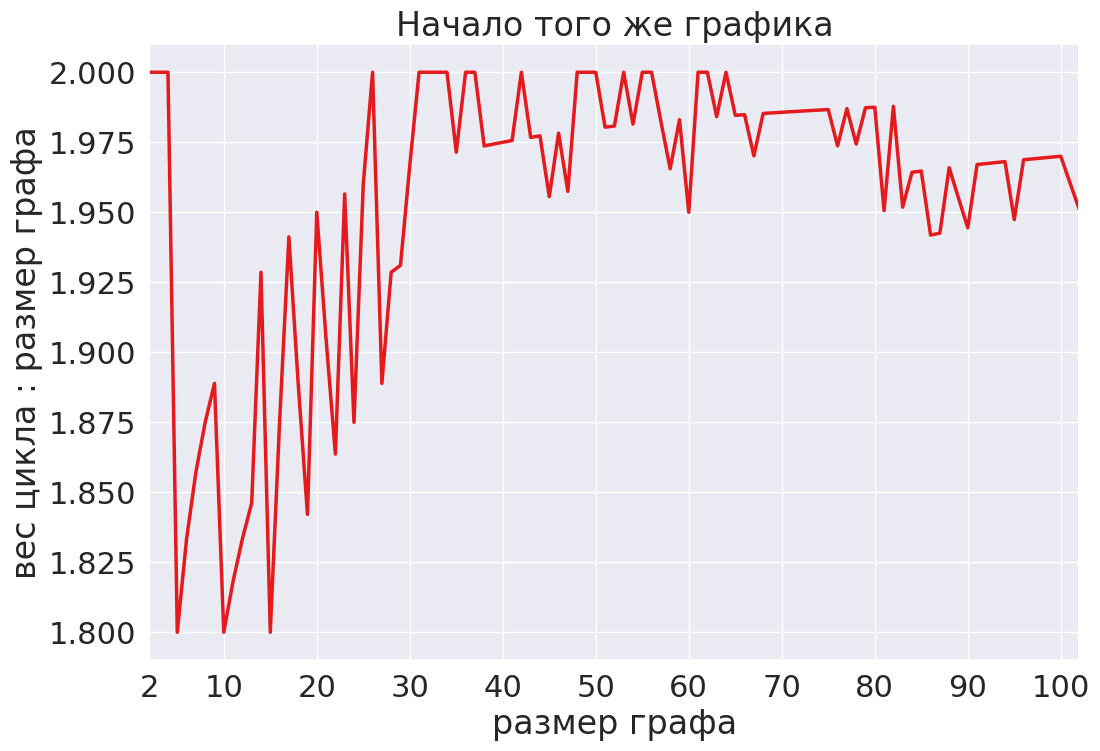

In [229]:
run_and_draw_and_save('RandomPermutationSolver', 'wiki_random_permutation_solver.csv')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [17:08<00:00,  1.03s/it]


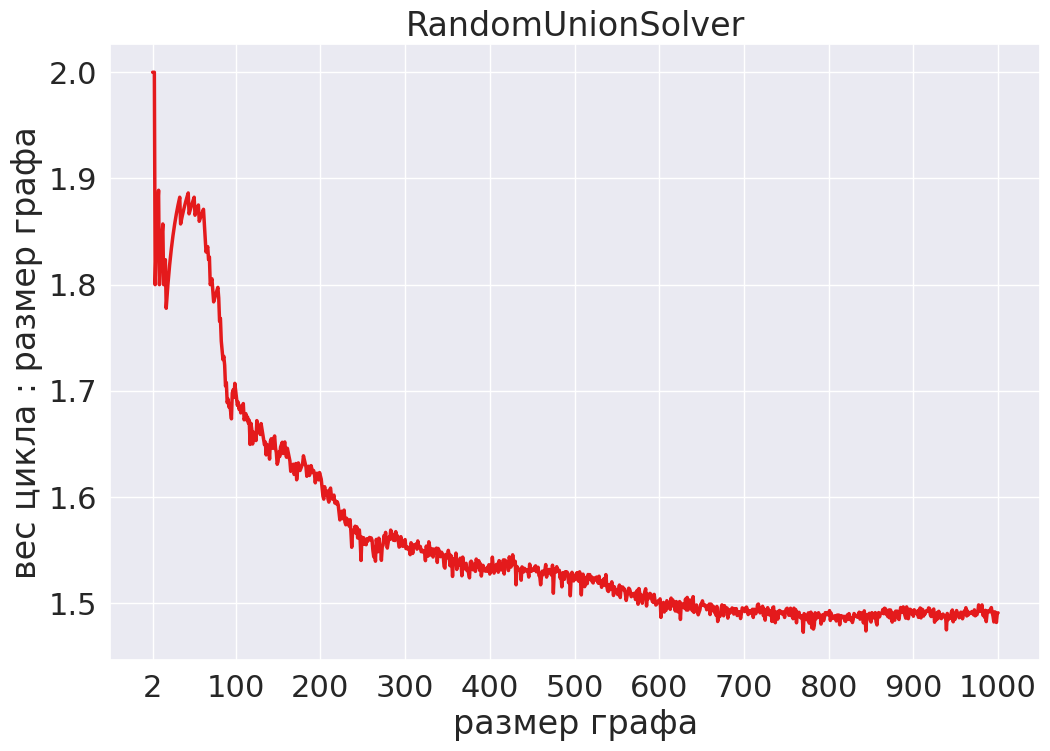

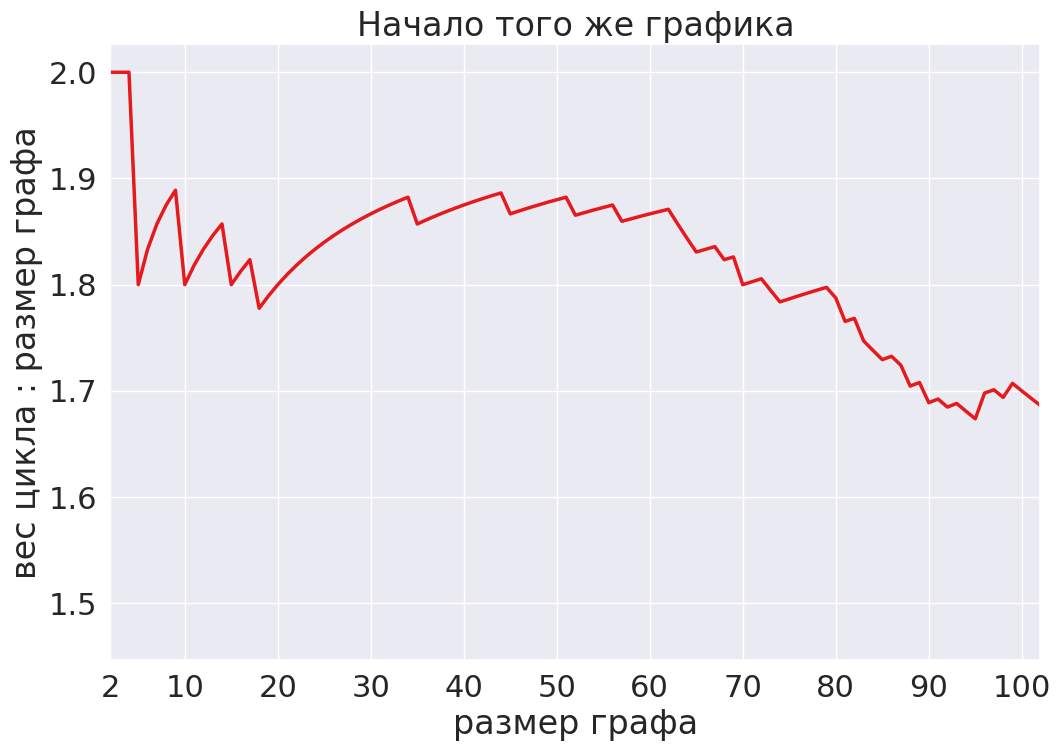

In [230]:
run_and_draw_and_save('RandomUnionSolver', 'wiki_random_union_solver.csv')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [17:08<00:00,  1.03s/it]


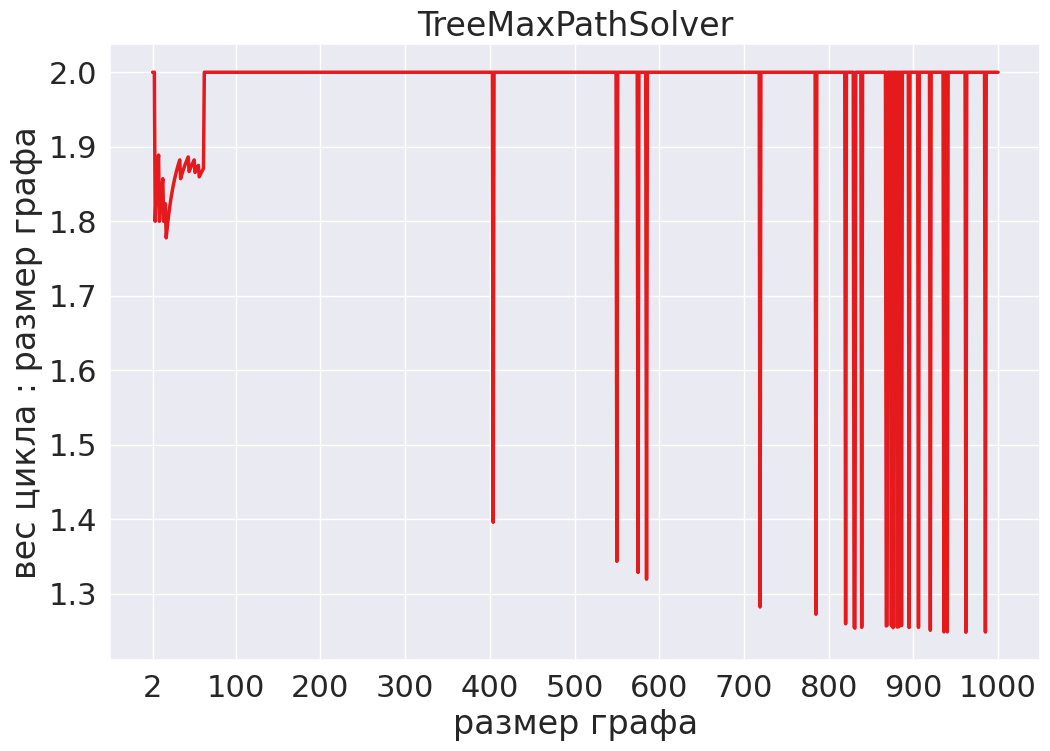

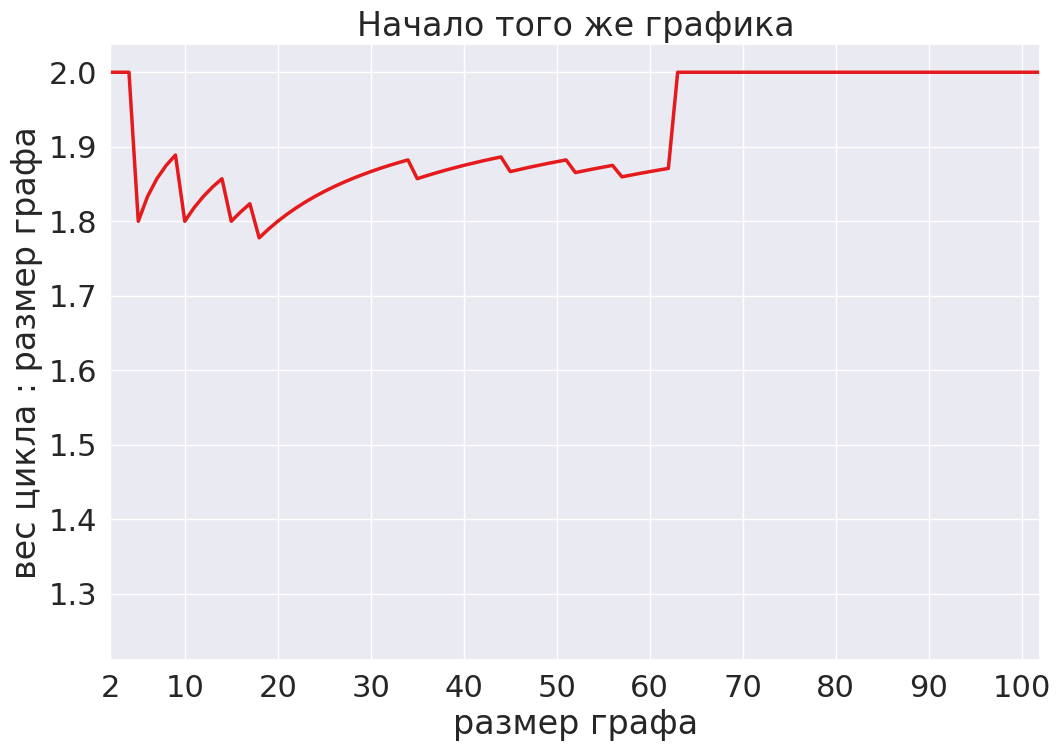

In [234]:
run_and_draw_and_save('TreeMaxPathSolver', 'wiki_tree_max_path_solver.csv')

In [15]:
FILES_CSV_WIKI = ['wiki_' + file for file in FILES_CSV]

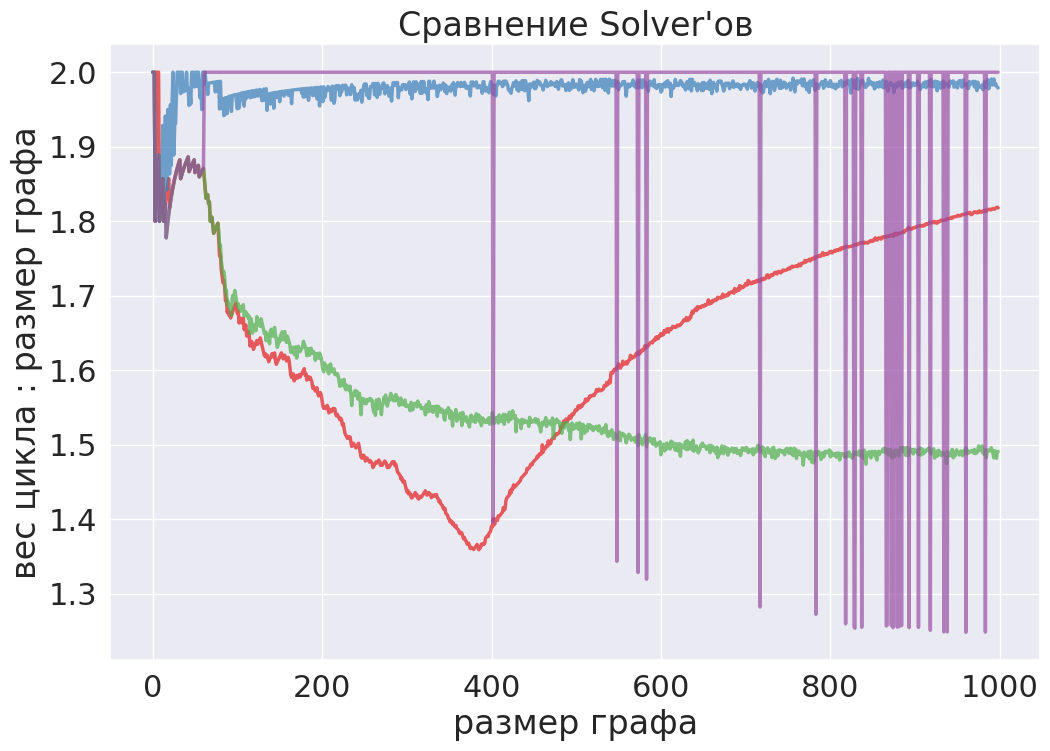

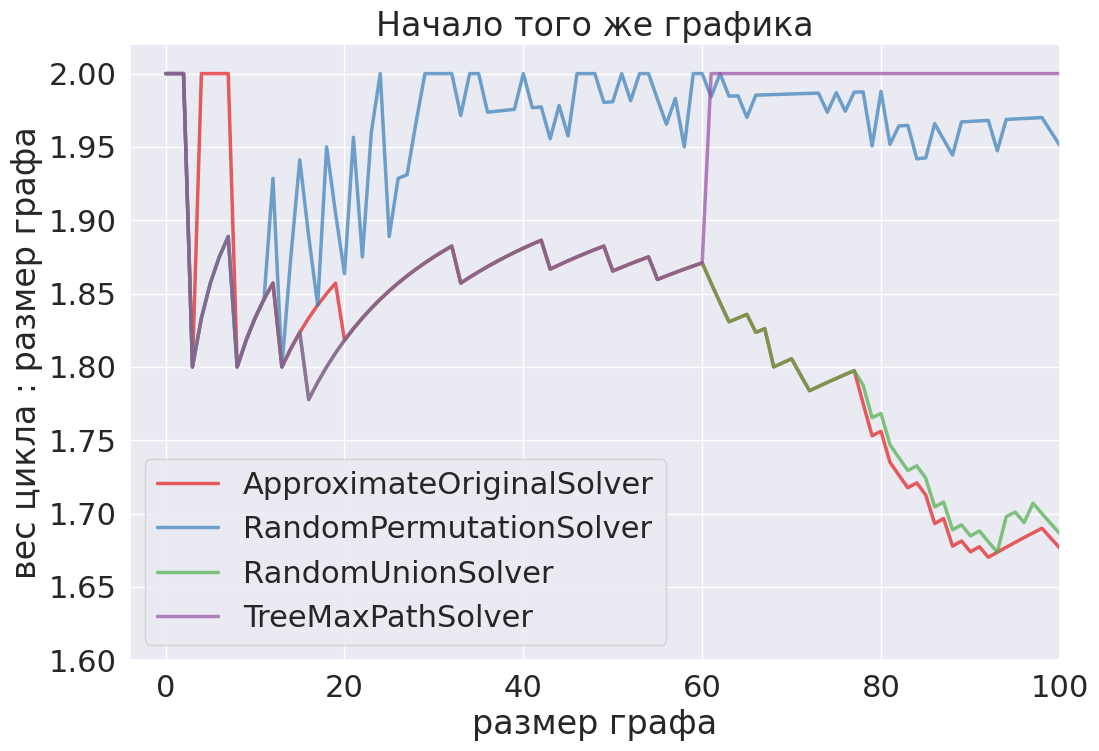

In [27]:
compare_solvers(FILES_CSV_WIKI, SOLVERS_NAMES, draw_legend=False)
compare_solvers(FILES_CSV_WIKI, SOLVERS_NAMES, 'Начало того же графика', True)
plt.xlim(-4, 100);
plt.ylim(1.6, 2.02);

###  <a id="moscow">[Дороги Москвы](#plan)</a>

Будем анализировать граф дорог Москвы [\[4\]](#sources4).

In [1]:
import osmnx as ox
import networkx as nx

In [2]:
def draw_osmnx(graph, title=''):
    fig, ax = ox.plot_graph(graph, show=False, close=False)

    if title:
        ax.set_title(title)
    plt.show()

In [3]:
latitude_moscow = 55.751351
longitude_moscow = 37.618824

In [4]:
def load_graph(dist, latitude=latitude_moscow, longitude=longitude_moscow):
    return ox.project_graph(ox.graph_from_point((latitude, longitude), dist=dist, network_type='drive'))

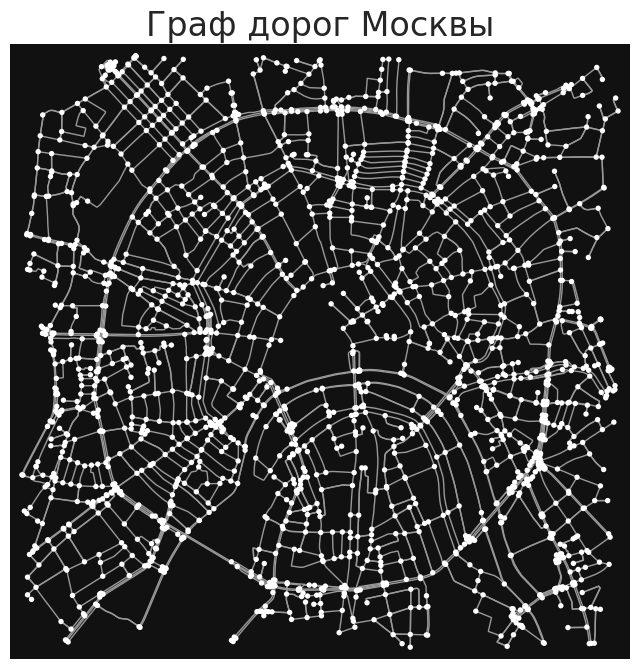

In [15]:
draw_osmnx(load_graph(3000), 'Граф дорог Москвы')

Поскольку мы рассматриваем графы размера $\leq$ 1000, будем рассматривать область меньшего радиуса.

In [40]:
max_distance = 2126

In [41]:
graph_moscow = load_graph(max_distance)

In [42]:
len(graph_moscow.nodes()), len(graph_moscow.edges())

(1002, 1905)

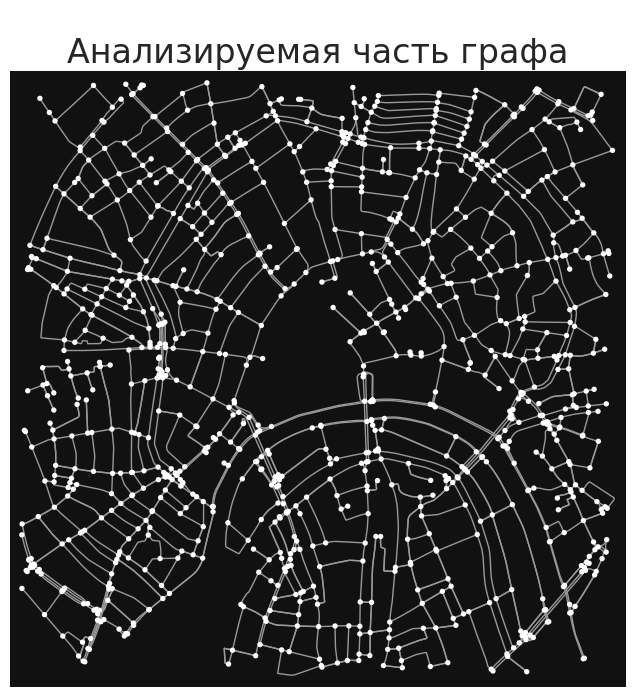

In [43]:
draw_osmnx(graph_moscow, 'Анализируемая часть графа')

Обойдем полученный граф bfs'ом, начиная от центральной. Будем запускать solver'ы на графах, содержащих первые $n$ вершин из bfs'а, где $2 \leq n \leq 1000$.

In [45]:
origin_node = ox.nearest_nodes(graph_moscow, latitude_moscow, longitude_moscow)

In [46]:
def bfs(start_node, edges):
    vertex_order = [start_node]
    
    graph = {}
    for edge in edges:
        graph.setdefault(edge[0], list())
        graph.setdefault(edge[1], list())
        
        graph[edge[0]].append(edge[1])
        graph[edge[1]].append(edge[0])
    
    pop_index = 0
    
    used = set()
    
    used.add(start_node)
    
    while pop_index < len(vertex_order):
        node = vertex_order[pop_index]
        pop_index += 1
        
        for child in graph[node]:
            if child in used:
                continue
            vertex_order.append(child)
            used.add(child)
            
    return vertex_order, graph

In [47]:
vertex_order, graph = bfs(origin_node, graph_moscow.edges())

In [48]:
get_vertex_index = {}
for i, vertex in enumerate(vertex_order):
    get_vertex_index[vertex] = i

100%|█████████████████████████████████████████| 999/999 [17:01<00:00,  1.02s/it]


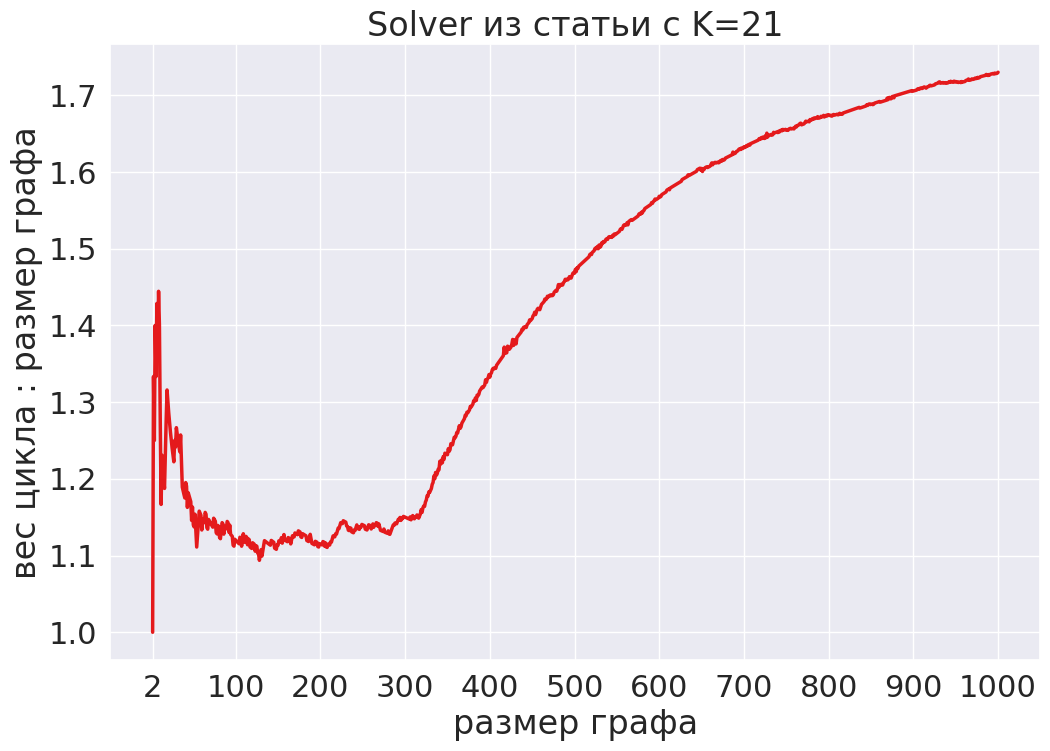

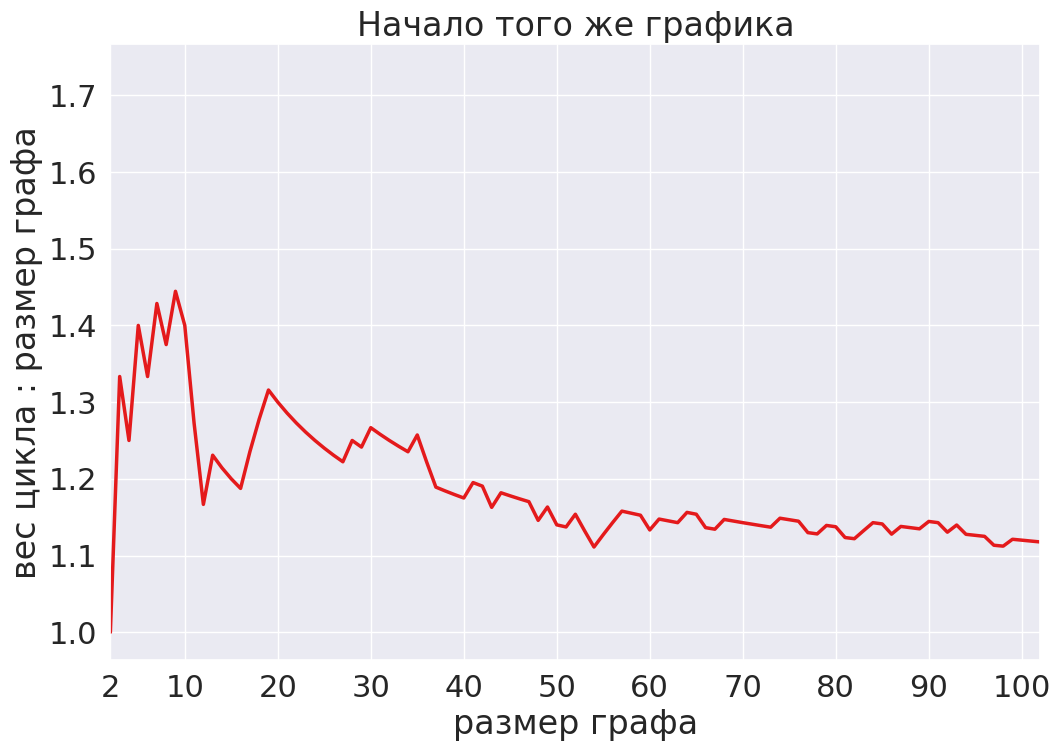

In [51]:
run_and_draw_and_save('Solver из статьи с K=21', 'moscow_approximate_original_solver_k21.csv')

100%|█████████████████████████████████████████| 999/999 [16:55<00:00,  1.02s/it]


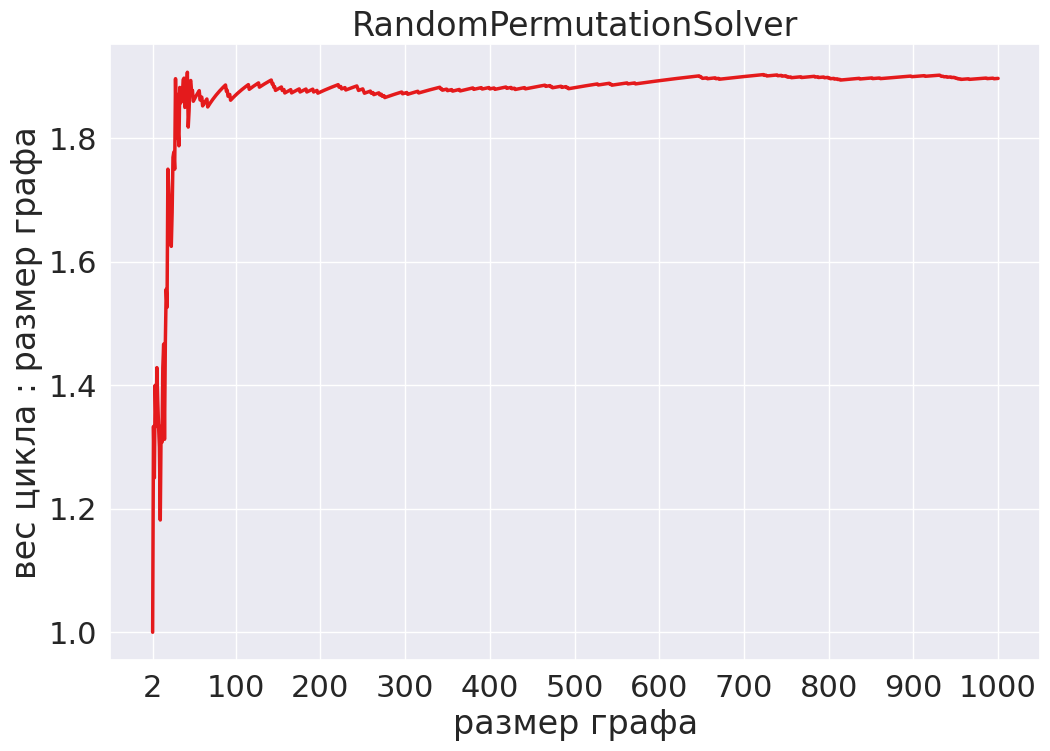

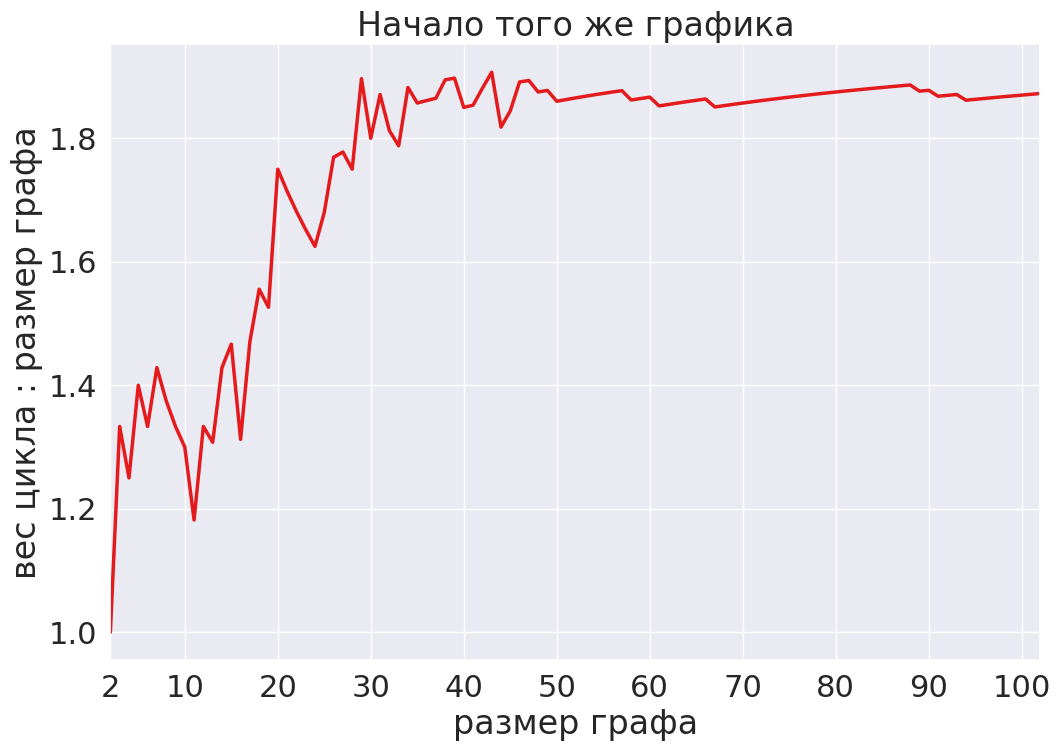

In [52]:
run_and_draw_and_save('RandomPermutationSolver', 'moscow_random_permutation_solver.csv')

100%|█████████████████████████████████████████| 999/999 [17:01<00:00,  1.02s/it]


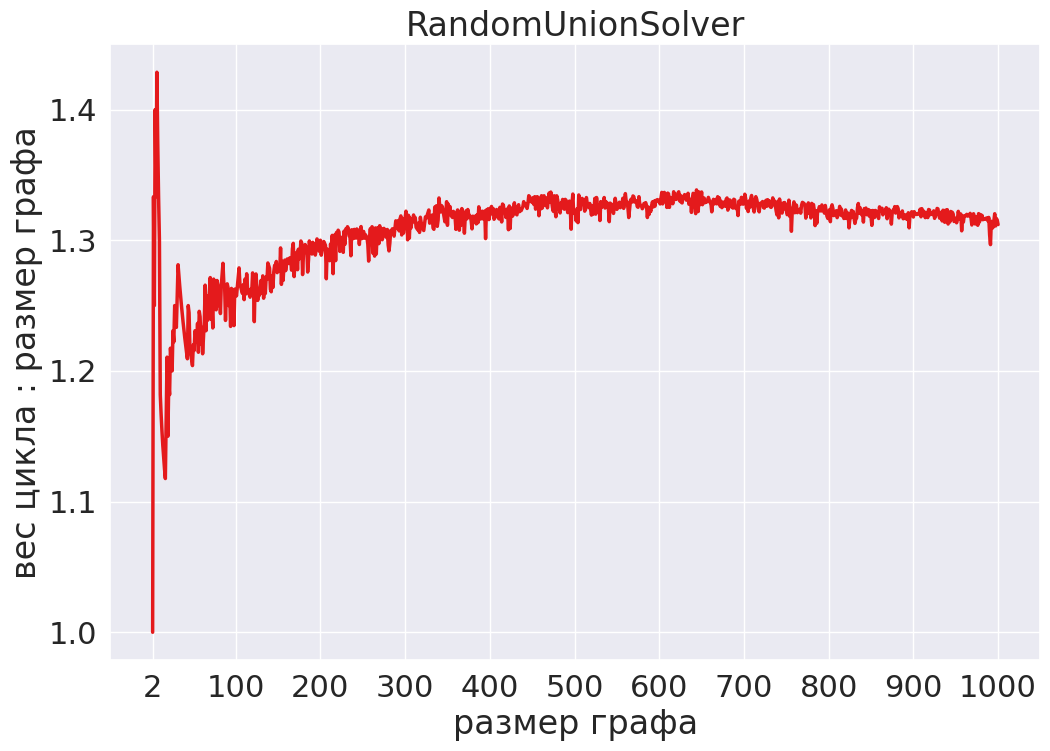

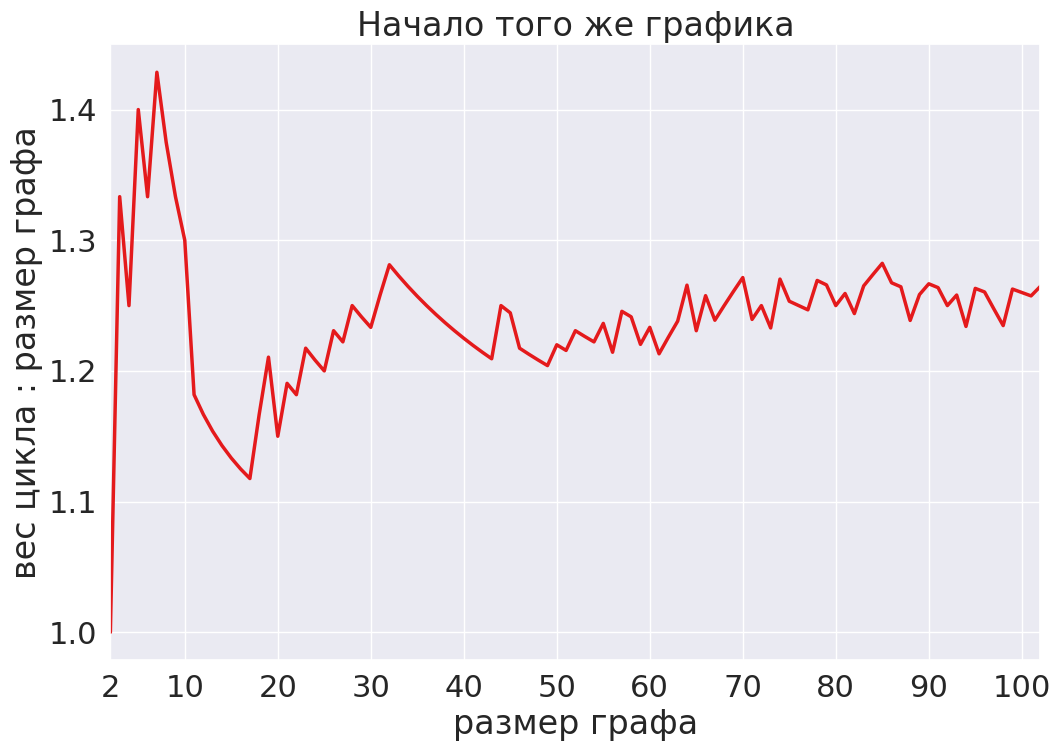

In [53]:
run_and_draw_and_save('RandomUnionSolver', 'moscow_random_union_solver.csv')

100%|█████████████████████████████████████████| 999/999 [17:05<00:00,  1.03s/it]


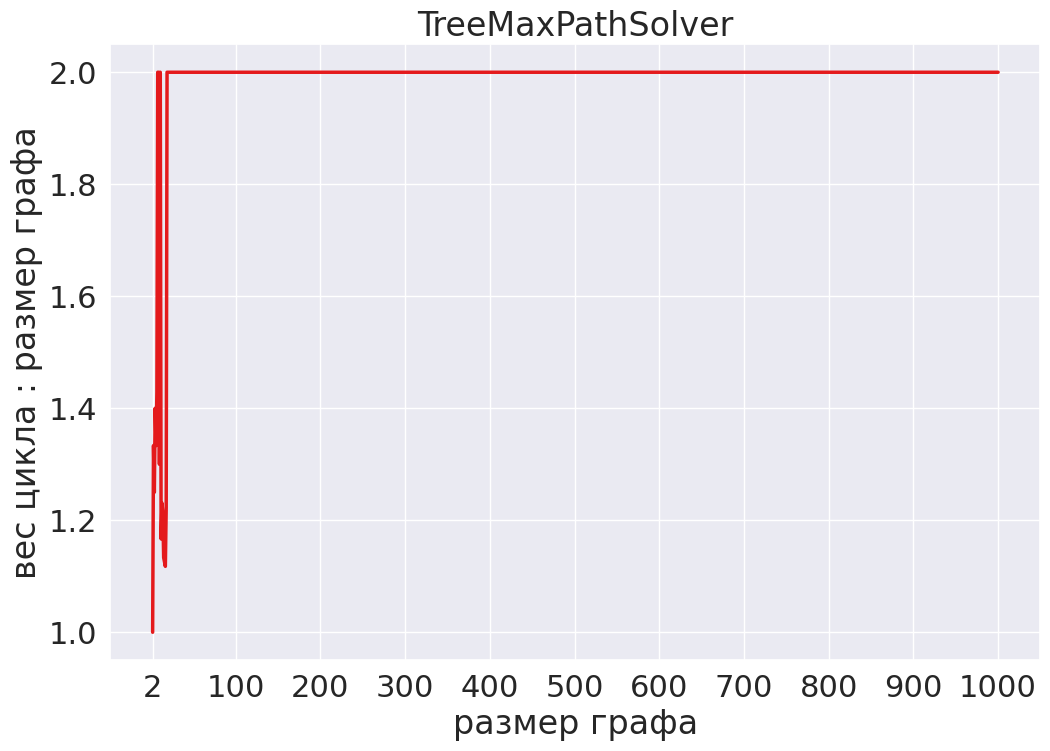

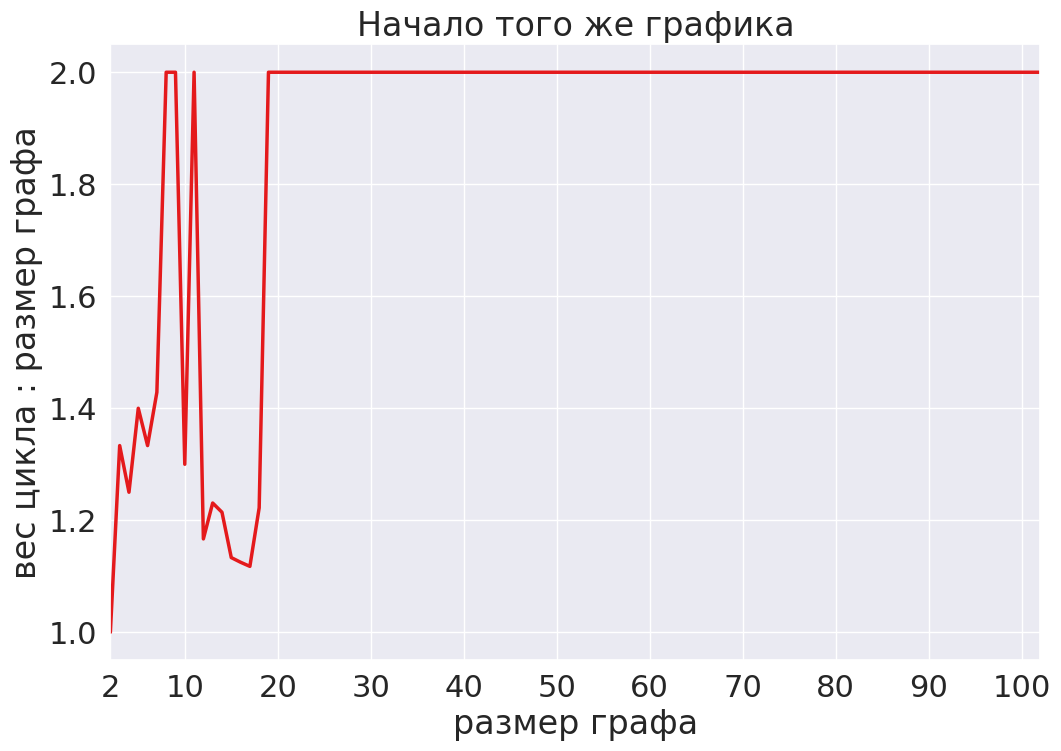

In [58]:
run_and_draw_and_save('TreeMaxPathSolver', 'moscow_tree_max_path_solver.csv')

In [61]:
FILES_CSV_MOSCOW = ['moscow_' + file for file in FILES_CSV]

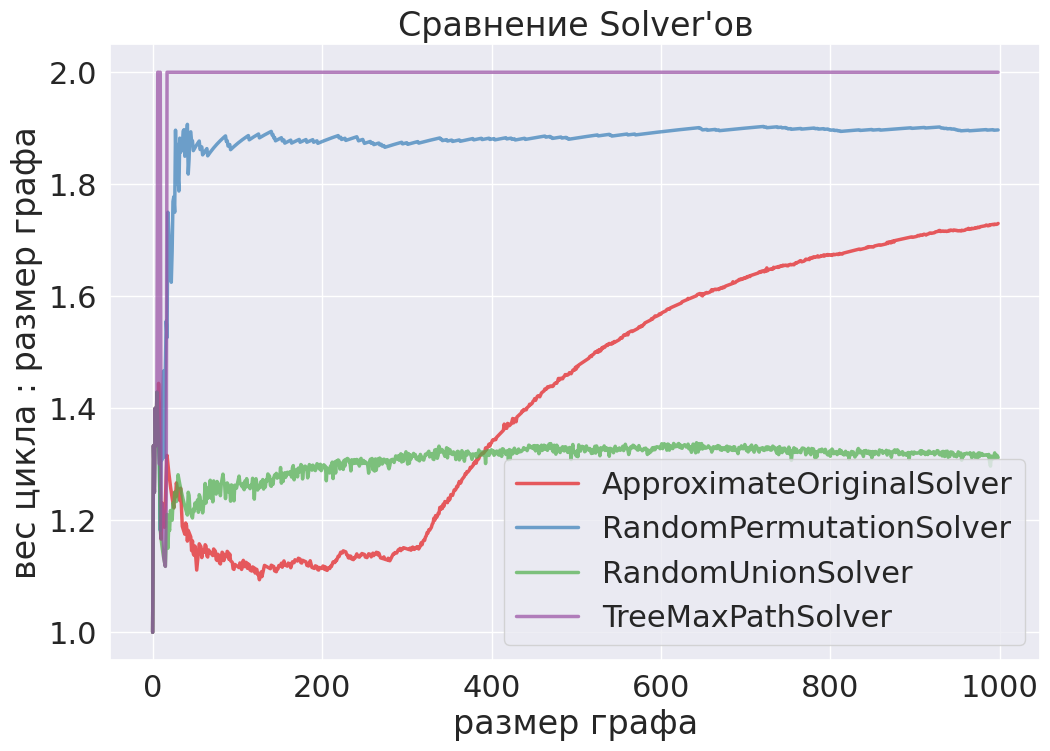

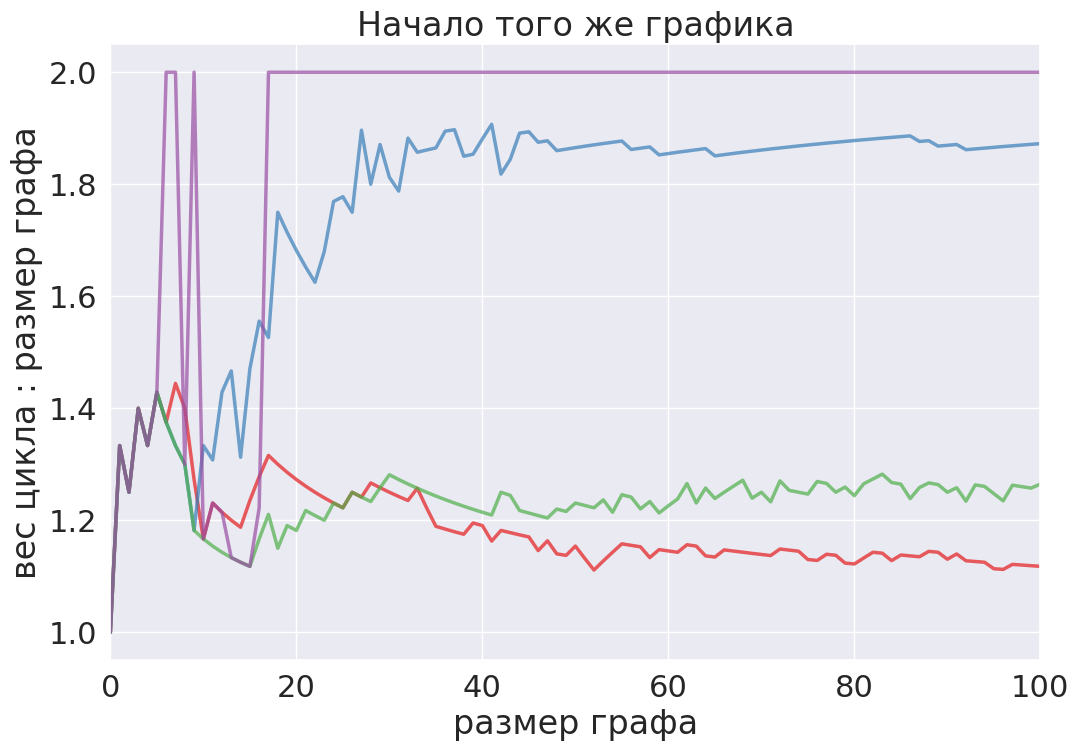

In [69]:
compare_solvers(FILES_CSV_MOSCOW, SOLVERS_NAMES, draw_legend=True)
compare_solvers(FILES_CSV_MOSCOW, SOLVERS_NAMES, 'Начало того же графика', False)
plt.xlim(0, 100);

## <a id="sources">[Источники](#plan)</a>

<a id="sources1">1.</a> 8/7-approximation algorithm for (1,2)-TSP P. Berman, M. Karpinski

<a id="sources2">2.</a>  D. Angluin and L. Valiant, “Fast probabilistic algorithms for hamiltonian circuits and matchings”, STOC ’77: Proceedings of the ninth annual ACM symposium on Theory of computing, 1977, pp. 30–41.

<a id="sources3">3.</a> Marek Karpinski and Richard Schmied. On approximation lower bounds for TSP with
bounded metrics. Electr. Colloquium Computat. Complexity, 19:8, 2012

<a id="sources4">4.</a> Openstreetmap: https://www.openstreetmap.org/